# Random Forest Classifier

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# classification model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#feature importance
from sklearn.inspection import permutation_importance

# metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

## Functions

Here we have some functions created to facilitate the modeling phase:

### Train-Test Split

In [2]:
def xy_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    return X_train, X_test, y_train, y_test

### Model Performance

In [3]:
def metrics_class(actual, predicted):
    kappa = cohen_kappa_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    f1 = f1_score(actual, predicted)
    auc_score = roc_auc_score(actual, predicted)
    
    index = ['Cohen Kappa Score', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC Score']
    metrics = pd.Series([kappa, accuracy, precision, recall, f1, auc_score], index=index)
    return metrics.round(2)

In [4]:
def plot_cm(actual, prediction):
    cm = confusion_matrix(actual, prediction)
    # Visualize confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Set2_r', fmt='g', ax=ax)

    # Set axis labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()



### Feature Importance

In [5]:
def importance(model, X_train):
    importances = pd.DataFrame(data=model.feature_importances_,
                        index= X_train.columns)
    importances_sorted = importances.iloc[:,0].sort_values(ascending=False)
    return importances_sorted.round(3)

In [6]:
def plot_importance(list):
    plt.figure(figsize=(18,8))
    plt.suptitle('Feature Importance Scores', y=0.95)
    plot = sns.barplot(x = list, y = list.index)
    return plot

In [7]:
def perm_importance(model, X, y):
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    train_result = permutation_importance(
        rf, X_train, y_train, n_repeats=10, random_state=1, n_jobs=2
    )
    test_results = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
    )
    sorted_importances_idx = train_result.importances_mean.argsort()[::-1]
    train_importances = pd.DataFrame(
        train_result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    test_importances = pd.DataFrame(
        test_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    return train_importances, test_importances

In [8]:
def plot_perm_impt(train_impt, test_impt):
    fig = plt.figure(figsize = (14,7))
    plt.suptitle("Permutation Importances", fontsize = 14, y=1)

    #  subplot #1
    plt.subplot(121)
    plt.title('Train Set')
    plt.xlabel("Decrease in accuracy score")
    ax = sns.boxplot(train_impt, orient='h', whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    
    #  subplot #2
    plt.subplot(122)
    plt.title('Test Set')
    plt.xlabel("Decrease in accuracy score")
    ax = sns.boxplot(test_impt, orient='h', whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    
    plt.tight_layout()
    plt.show()

## Model

In [9]:
rf = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

## Load Datasets

### Original Data

In [10]:
X = df = pd.read_csv(r'./../data/X.csv')
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [11]:
y = df = pd.read_csv(r'./../data/y.csv')
y.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No


In [12]:
# Change y into dummies 0 and 1
y_int = pd.Series(y.offer_accepted)
y_int = y_int.apply(lambda x: 0 if x == 'No' else 1)
y_int.value_counts()

offer_accepted
0    16955
1     1021
Name: count, dtype: int64

In [13]:
# Apply Transformation on X
independents = X.copy() # make a separate df to preserve the column headers

transformer = StandardScaler().fit(independents)
standard_x = transformer.transform(independents)
X = pd.DataFrame(standard_x)
X.columns = independents.columns # put the column headers back
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.223349,-0.267589,0.095704,0.343147,1.410295,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-1.405430,-1.953241,-1.741902,-0.794628,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,-0.876449,-1.415407,-1.620841,-1.016458,1.410295,-0.007894,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,1.076589,1.662932,0.139070,-0.699813,-0.005039,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,1.982953,0.781845,-0.108474,-0.796417,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147


#### X Variation: Remove 4 columns of Quarter Balances

In [14]:
# Remove the quarterly balances to eliminate multicollinearity
X_avgbal = X.drop(columns=(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']))
X_avgbal

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.410295,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,1.410295,-0.007894,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,-0.005039,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,-0.541352,-1.133443,-0.476212,1.346760,-2.206799,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
17972,-0.541352,1.375766,-0.476212,-0.447855,-0.256976,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
17973,-0.541352,0.121161,-0.476212,0.449452,0.418896,1.410295,-1.231249,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
17974,-0.541352,2.630370,1.863330,-1.345162,0.233335,-0.005039,-0.007894,-0.711980,1.413683,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147


### SMOTE Data

In [15]:
smote_data = pd.read_csv(r'./../data/oversampled_data.csv')
smote_data.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,...,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes,offer_accepted
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.223349,-0.267589,0.095704,0.343147,1.410295,...,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744,No
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-1.405430,-1.953241,-1.741902,-0.794628,-0.005039,...,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147,No
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,-0.876449,-1.415407,-1.620841,-1.016458,1.410295,...,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147,No
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,1.076589,1.662932,0.139070,-0.699813,-0.005039,...,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744,No
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,1.982953,0.781845,-0.108474,-0.796417,-0.005039,...,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147,No


In [16]:
X_sm = smote_data.drop('offer_accepted', axis=1)
X_sm.columns.to_list()

['bank_accounts_open',
 'credit_cards_held',
 'homes_owned',
 'household_size',
 'average_balance',
 'q1_balance',
 'q2_balance',
 'q3_balance',
 'q4_balance',
 'income_level',
 'credit_rating',
 'reward_Air Miles',
 'reward_Cash Back',
 'reward_Points',
 'mailer_type_Letter',
 'mailer_type_Postcard',
 'overdraft_protection_No',
 'overdraft_protection_Yes',
 'own_your_home_No',
 'own_your_home_Yes']

In [17]:
y_sm = smote_data.iloc[:, -1]
y_sm = y_sm.map({'No': 0, 'Yes': 1})
y_sm.value_counts()

offer_accepted
0    16955
1    16955
Name: count, dtype: int64

#### X Variation: Remove 4 columns of Quarter Balances

In [18]:
# Remove the quarterly balances to eliminate multicollinearity
Xsm_avgbal = X_sm.drop(columns=(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']))
Xsm_avgbal

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.410295,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,1.410295,-0.007894,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,-0.005039,1.215460,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,-0.005039,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33905,1.575537,0.365992,1.406778,1.171654,-2.006040,-1.144176,0.230839,1.404533,-0.707372,-0.701980,-0.983886,0.983886,0.418213,-0.418213,1.354744,-1.354744
33906,-0.541352,0.121161,-0.476212,-1.339703,0.509354,-1.420373,-0.007894,1.404533,-0.707372,-0.701980,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
33907,-0.541352,-0.742960,-0.476212,-1.345162,0.100980,-0.445548,-0.850492,-0.711980,1.413683,-0.701980,-0.983886,0.983886,-2.391127,2.391127,0.703352,-0.703352
33908,-0.541352,0.121161,-0.476212,0.207690,0.117587,0.376295,-0.337504,-0.711980,-0.707372,1.424543,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744


### Add random variable in X
- This variable will be useful when checking for feature importance. Every variable below it could most likely be dropped.

In [19]:
X['random'] = np.random.random(size=len(X))
X_avgbal['random'] = np.random.random(size=len(X_avgbal))
X_sm['random'] = np.random.random(size=len(X_sm))
Xsm_avgbal['random'] = np.random.random(size=len(Xsm_avgbal))

## Modeling

### Original Data

In [20]:
# Original Data
X_train, X_test, y_train, y_test = xy_split(X, y_int)

In [21]:
#Checking the number of records
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(12583, 21) 12583
(5393, 21) 5393


In [22]:
# Fitting to the Training Set
rf.fit(X_train,y_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

rf_pred = rf.predict(X_test)

Training Accuracy Score: 1.00 
OOB Score: 0.94 
Validation Accuracy Score: 0.94


In [23]:
rf_metrics = metrics_class(y_test, rf_pred)
rf_metrics

Cohen Kappa Score   -0.00
Accuracy             0.94
Precision            0.00
Recall               0.00
F1                   0.00
AUC Score            0.50
dtype: float64

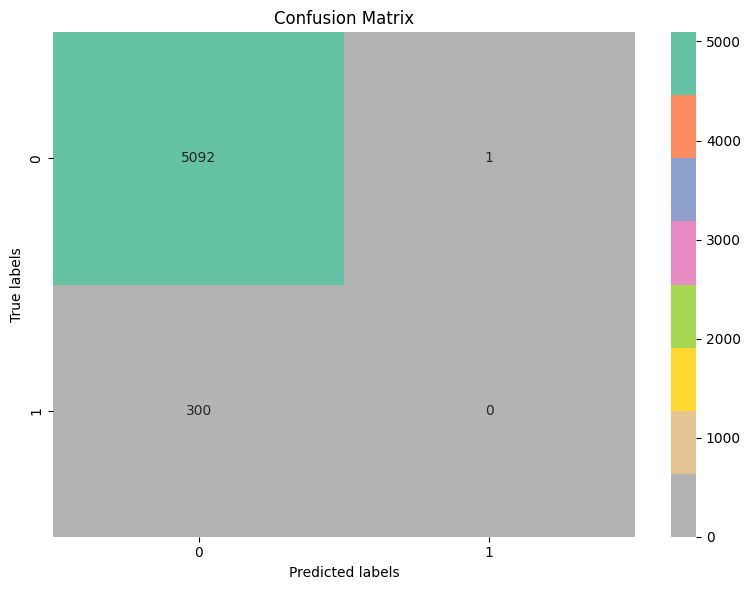

In [24]:
plot_cm(y_test, rf_pred)

#### Feature Importance

In [25]:
imp_rf = importance(rf, X_train)
imp_rf

q3_balance                  0.124
random                      0.122
q2_balance                  0.122
q1_balance                  0.121
average_balance             0.121
q4_balance                  0.119
household_size              0.050
credit_rating               0.036
credit_cards_held           0.033
income_level                0.026
bank_accounts_open          0.017
homes_owned                 0.017
own_your_home_Yes           0.012
own_your_home_No            0.012
reward_Air Miles            0.012
reward_Points               0.011
overdraft_protection_No     0.010
overdraft_protection_Yes    0.009
reward_Cash Back            0.009
mailer_type_Postcard        0.009
mailer_type_Letter          0.007
Name: 0, dtype: float64

<Axes: xlabel='0'>

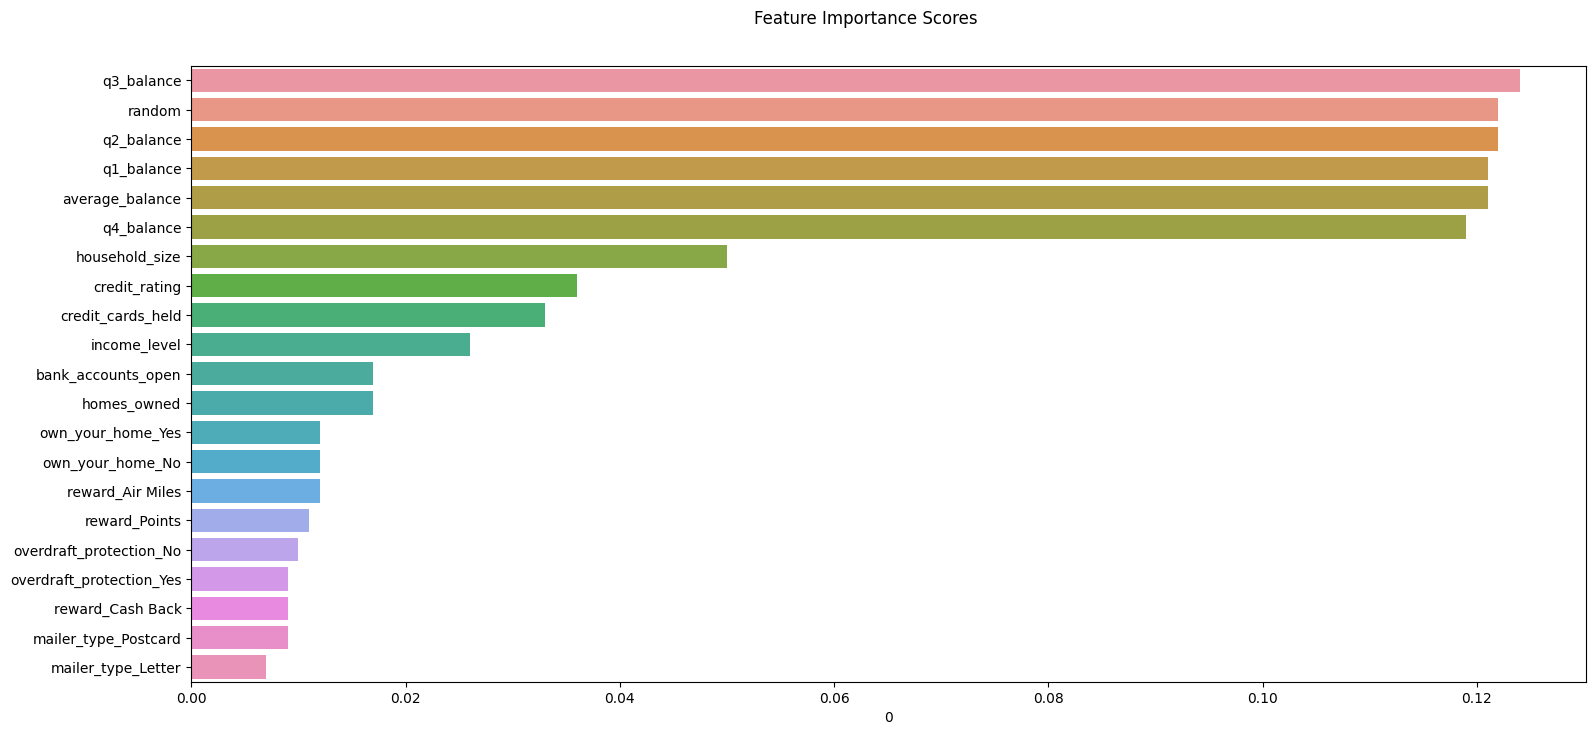

In [26]:
plot_importance(imp_rf)

> **Note:** Feature importance shows that the random variable is more important than the other features from the dataset which doesn't make sense. We will check permutation importance instead to see if the ranking will change.
> 
> The impurity-based feature importance ranks the numerical features to be the most important features. As a result, the non-predictive random_num variable is ranked as one of the most important features.
> This problem stems from two limitations of impurity-based feature importances:
>   - impurity-based importances are biased towards high cardinality features;
>   - impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

#### Permutation Importance

In [27]:
train_impt, test_impt = perm_importance(rf, X, y_int)

> **Note:** Permutation Importance takes a longer time to compute.

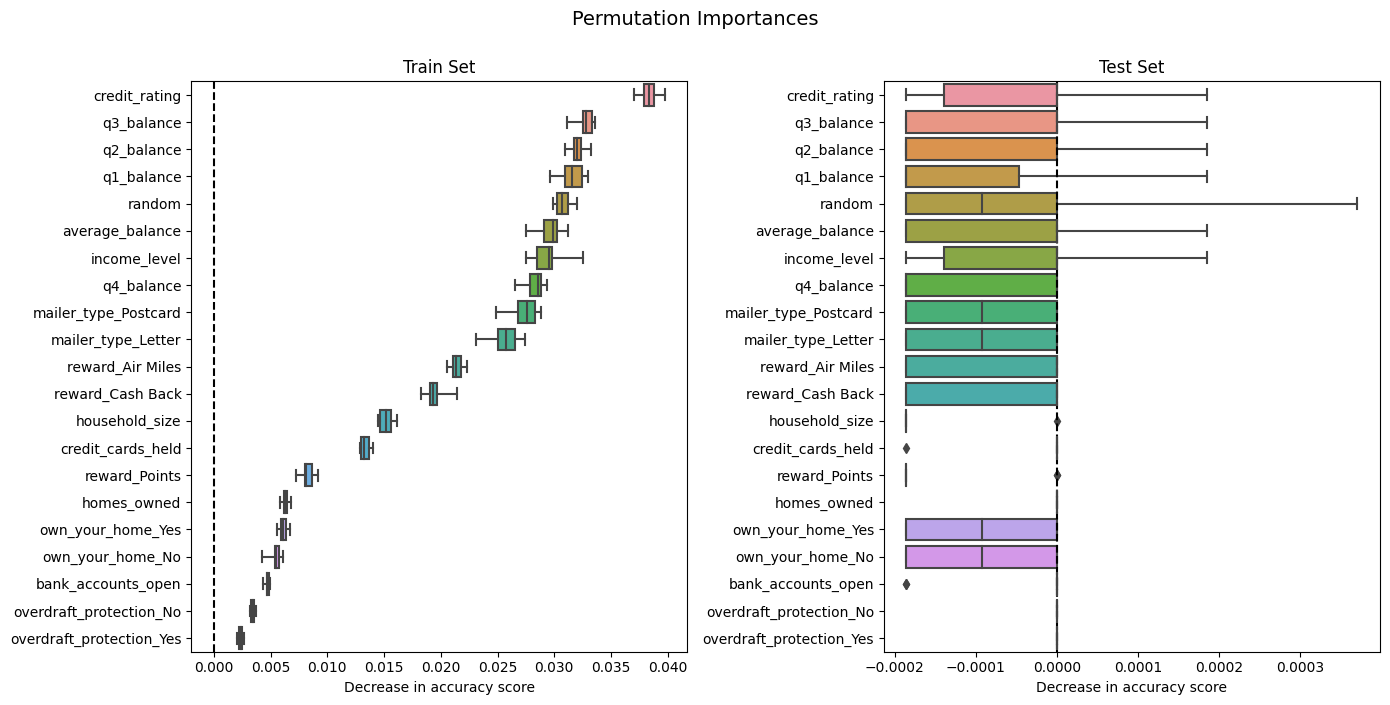

In [28]:
plot_perm_impt(train_impt, test_impt)

> **Top Variables (above random):**
> 1. credit_rating
> 2. q1 balance
> 3. q3 balance
> 4. q2_balance
>
> Here are the top variables according the permutation importance. However, we can see from the graph that the decrease in accuracy score is not very significant.

### Original with X Variation: Remove 4 columns of Quarter Balances

In [29]:
## Original without quarterly balances
Xavg_train, Xavg_test, yavg_train, yavg_test = xy_split(X_avgbal, y_int)

In [30]:
#Checking the number of records
print(Xavg_train.shape, len(y_train))
print(Xavg_test.shape, len(y_test))

(12583, 17) 12583
(5393, 17) 5393


In [31]:
# Fitting to the Training Set
rf.fit(Xavg_train,yavg_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(Xavg_train,yavg_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(Xavg_test, yavg_test)))

rf_avg_pred = rf.predict(Xavg_test)

Training Accuracy Score: 1.00 
OOB Score: 0.94 
Validation Accuracy Score: 0.94


In [32]:
rf_avg_metrics = metrics_class(yavg_test,rf_avg_pred)
rf_avg_metrics

Cohen Kappa Score    0.00
Accuracy             0.94
Precision            0.11
Recall               0.00
F1                   0.01
AUC Score            0.50
dtype: float64

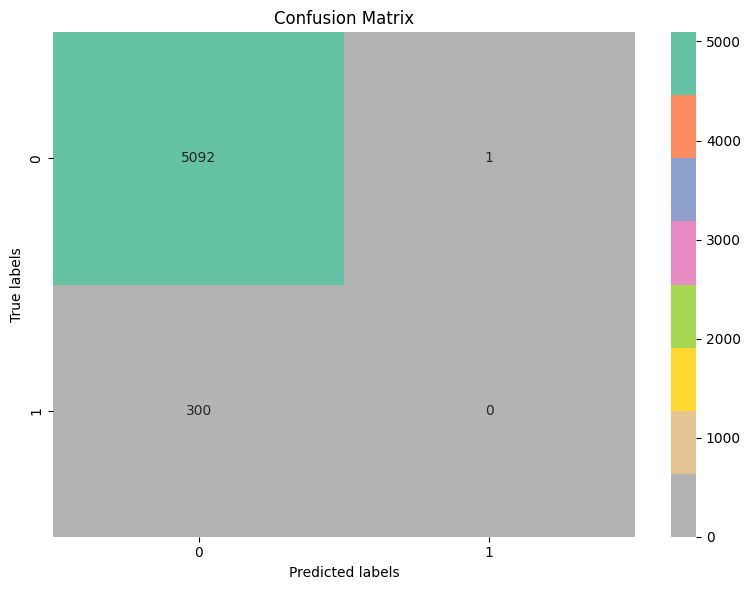

In [33]:
plot_cm(y_test, rf_pred)

#### Feature Importance

In [34]:
imp_rf_avg = importance(rf, Xavg_train)
imp_rf_avg

random                      0.300
average_balance             0.294
household_size              0.093
credit_cards_held           0.062
credit_rating               0.044
income_level                0.040
bank_accounts_open          0.034
homes_owned                 0.030
own_your_home_No            0.015
own_your_home_Yes           0.015
overdraft_protection_Yes    0.012
overdraft_protection_No     0.012
reward_Air Miles            0.011
reward_Points               0.011
reward_Cash Back            0.009
mailer_type_Letter          0.008
mailer_type_Postcard        0.007
Name: 0, dtype: float64

<Axes: xlabel='0'>

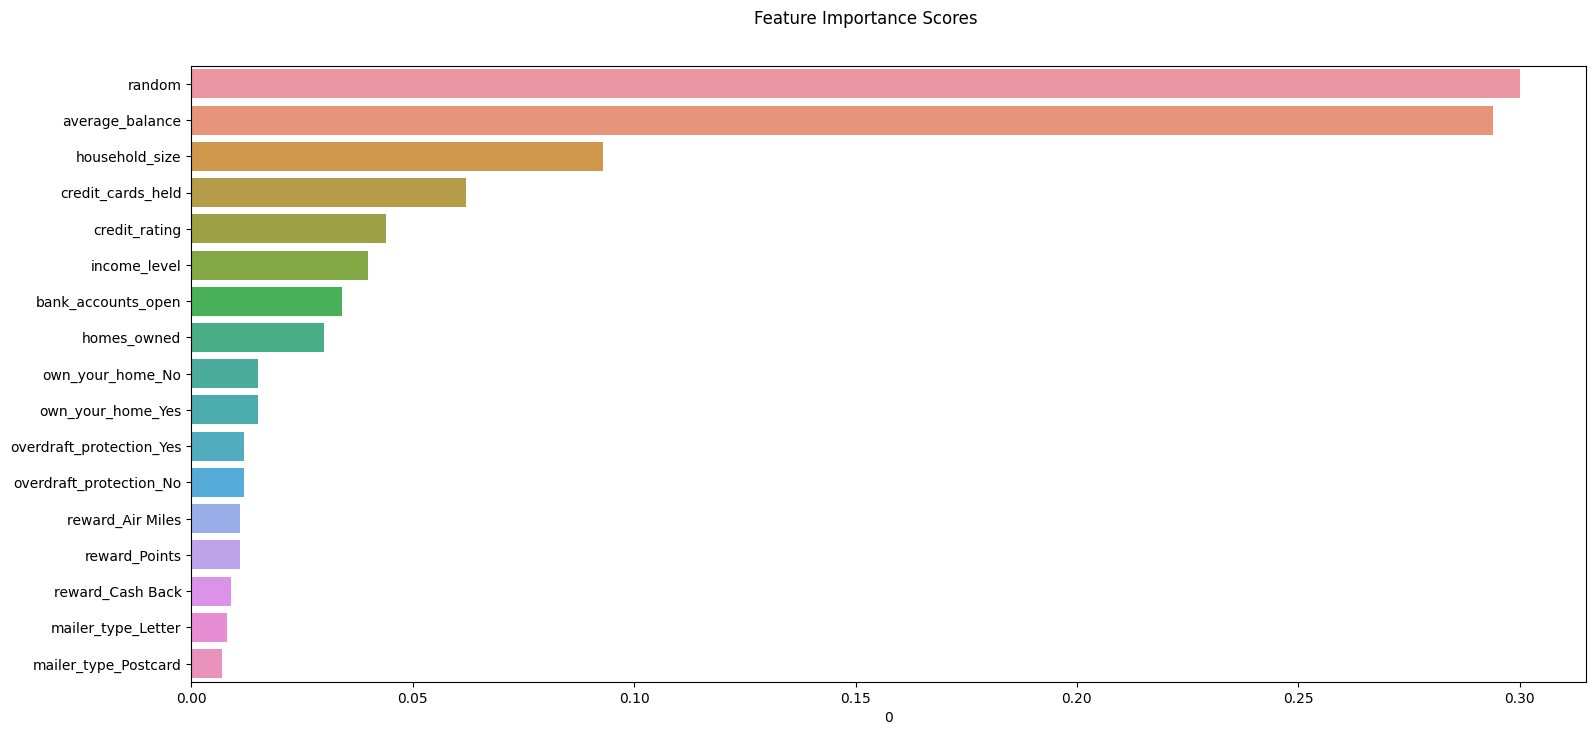

In [35]:
plot_importance(imp_rf_avg)

#### Permutation Importance

In [36]:
train_impt, test_impt = perm_importance(rf, X_avgbal, y_int)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


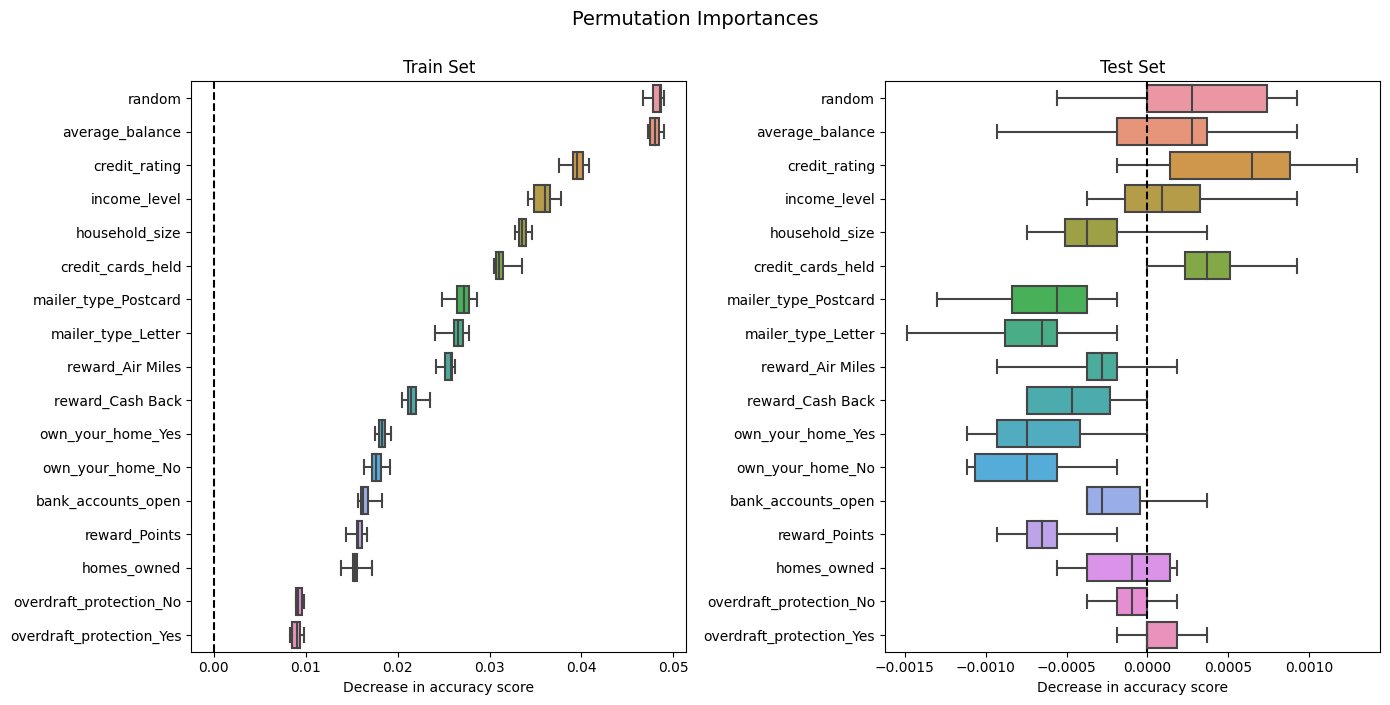

In [37]:
plot_perm_impt(train_impt, test_impt)

> Without the quarterly balances, the variables with the highest cardinality which is average_balance and the random variable are considered the most important features.

### SMOTE Data

In [38]:
# SMOTE Data
Xsm_train, Xsm_test, ysm_train, ysm_test = xy_split(X_sm, y_sm)

In [39]:
#Checking the number of records
print(Xsm_train.shape, len(ysm_train))
print(Xsm_test.shape, len(ysm_test))

(23737, 21) 23737
(10173, 21) 10173


In [40]:
# Fitting to the Training Set
rf.fit(Xsm_train,ysm_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(Xsm_train,ysm_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(Xsm_test, ysm_test)))

sm_rf_pred = rf.predict(Xsm_test)

Training Accuracy Score: 1.00 
OOB Score: 0.97 
Validation Accuracy Score: 0.97


In [41]:
sm_rf_metrics = metrics_class(ysm_test, sm_rf_pred)
sm_rf_metrics

Cohen Kappa Score    0.94
Accuracy             0.97
Precision            0.97
Recall               0.96
F1                   0.97
AUC Score            0.97
dtype: float64

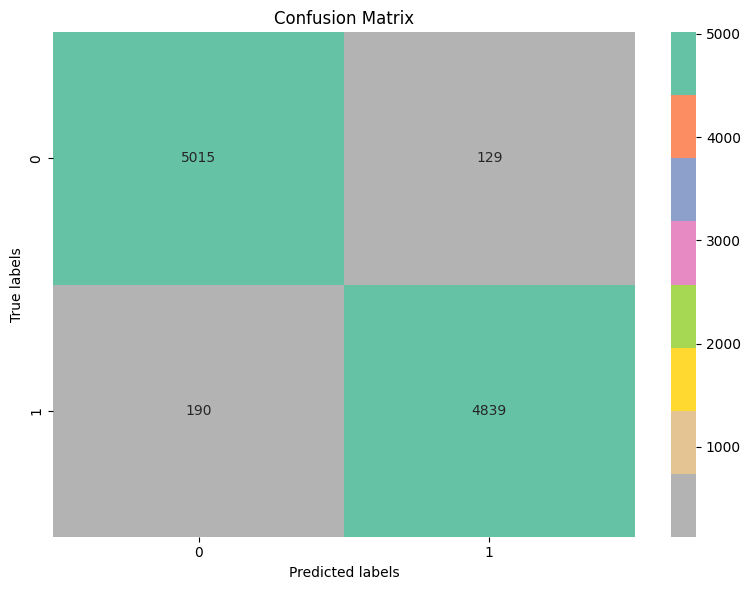

In [42]:
plot_cm(ysm_test, sm_rf_pred)

#### Feature Importance

In [43]:
imp_sm_rf = importance(rf, Xsm_train)
imp_sm_rf

credit_rating               0.225
income_level                0.128
household_size              0.089
credit_cards_held           0.083
q4_balance                  0.056
q2_balance                  0.056
q1_balance                  0.055
q3_balance                  0.052
average_balance             0.050
random                      0.028
mailer_type_Postcard        0.028
reward_Cash Back            0.024
mailer_type_Letter          0.024
bank_accounts_open          0.023
homes_owned                 0.018
reward_Air Miles            0.018
reward_Points               0.011
own_your_home_Yes           0.010
own_your_home_No            0.009
overdraft_protection_No     0.006
overdraft_protection_Yes    0.006
Name: 0, dtype: float64

<Axes: xlabel='0'>

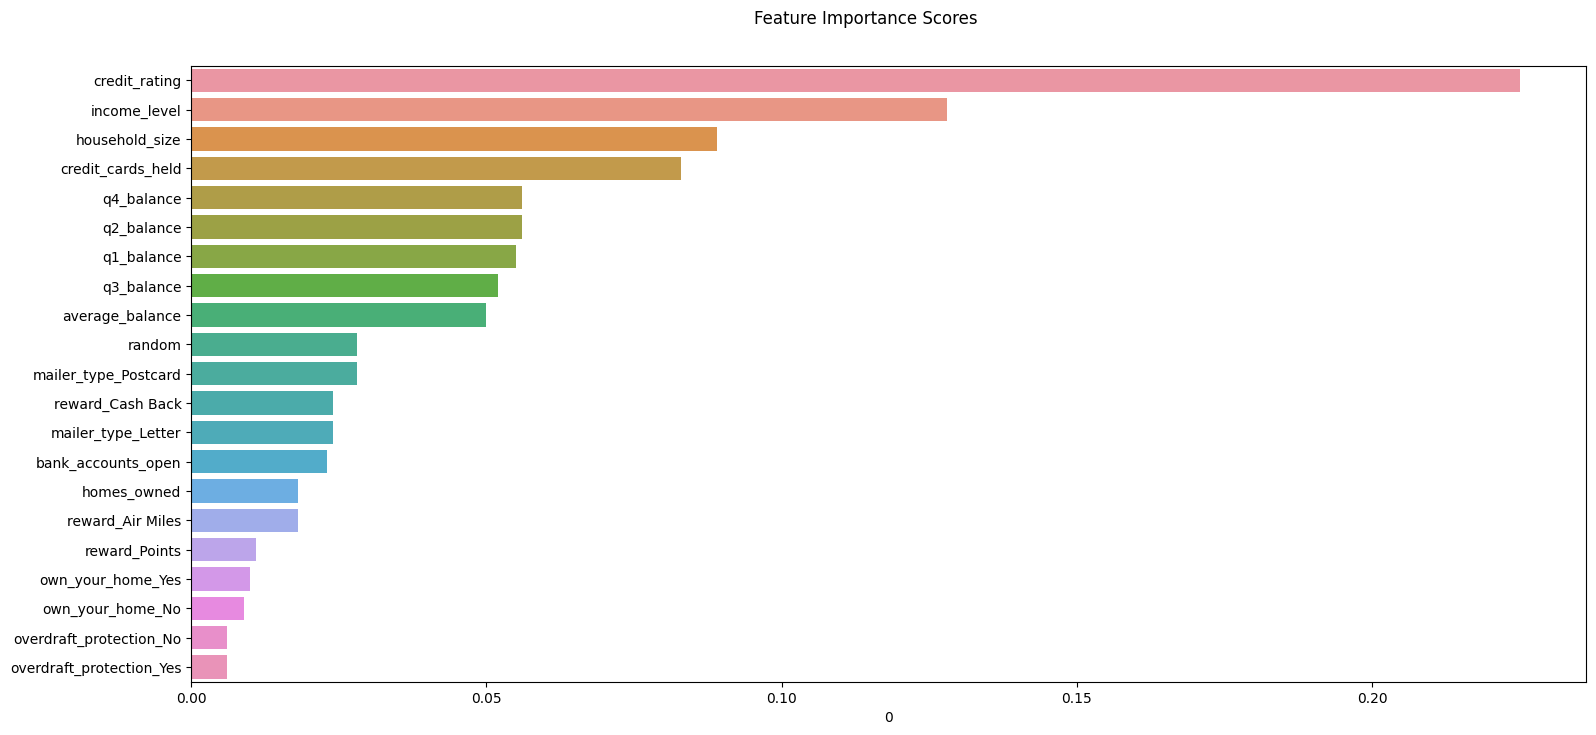

In [44]:
plot_importance(imp_sm_rf)

#### Permutation Importance

In [45]:
train_impt, test_impt = perm_importance(rf, X_sm, y_sm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


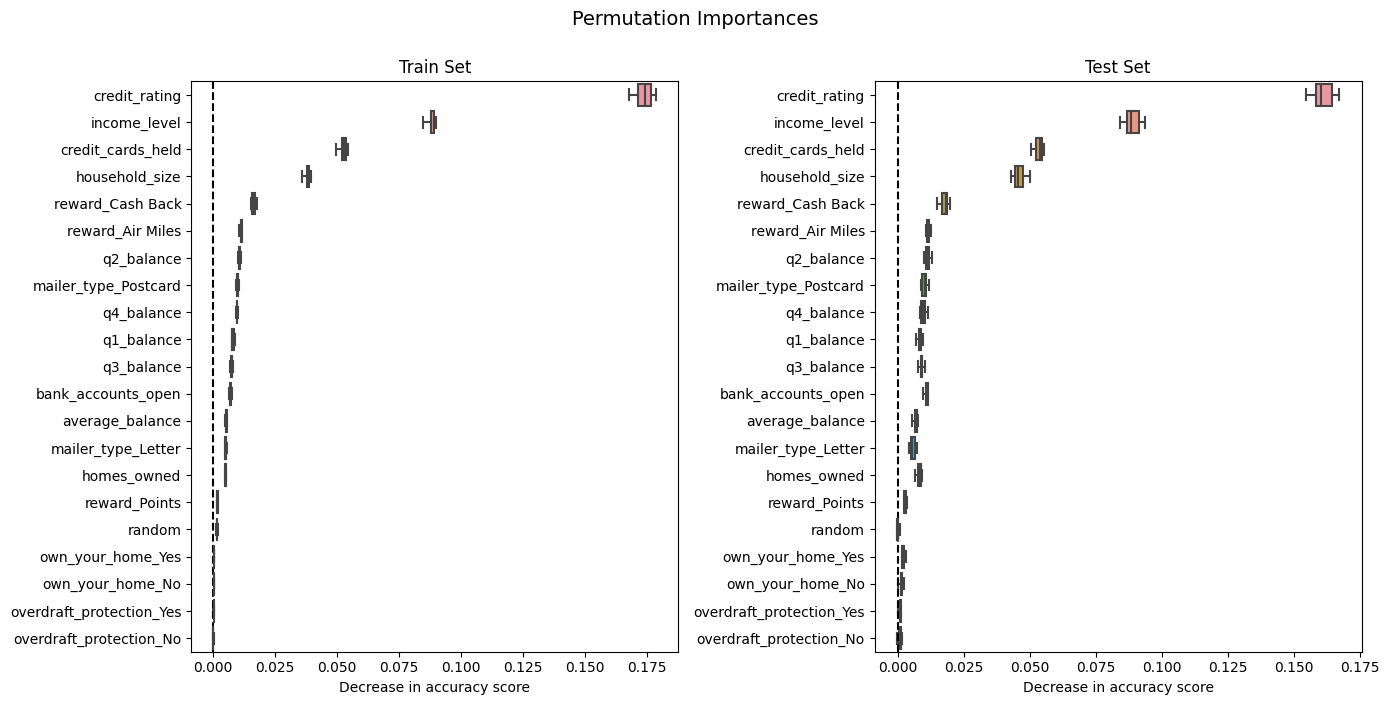

In [46]:
plot_perm_impt(train_impt, test_impt)

> **Note:** We can see that with synthetic data, the predictive power of the model is much higher. Without the imbalanced data, we are now able to predict which customers would accept the credit card offer.
>
> In terms of feature importance, here are the top 5 variables we found:
> 1. credit_rating
> 2. income_level
> 3. household_size
> 4. credit_cards_held
> 5. q4_balance
>
> Meanwhile, permutation importance yields:
> 1. credit_rating
> 2. income_level
> 3. credit_cards_held
> 4. household_size
> 5. rewards_Cash Back
>
> We can also see similarities in the features that were considered important by both methods of feature importance.

### SMOTE Data with X Variation: Remove 4 columns of Quarter Balances

In [47]:
## SMOTE Data without quarterly balances
Xsmavg_train, Xsmavg_test, ysmavg_train, ysmavg_test = xy_split(Xsm_avgbal, y_sm)

In [48]:
#Checking the number of records
print(Xsmavg_train.shape, len(ysmavg_train))
print(Xsmavg_test.shape, len(ysmavg_test))

(23737, 17) 23737
(10173, 17) 10173


In [49]:
# Fitting to the Training Set
rf.fit(Xsmavg_train,ysmavg_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(Xsmavg_train,ysmavg_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(Xsmavg_test, ysmavg_test)))

sm_rf_avg_pred = rf.predict(Xsmavg_test)

Training Accuracy Score: 1.00 
OOB Score: 0.95 
Validation Accuracy Score: 0.96


In [50]:
sm_rf_avg_metrics = metrics_class(ysmavg_test, sm_rf_avg_pred)
sm_rf_avg_metrics

Cohen Kappa Score    0.91
Accuracy             0.96
Precision            0.97
Recall               0.95
F1                   0.96
AUC Score            0.96
dtype: float64

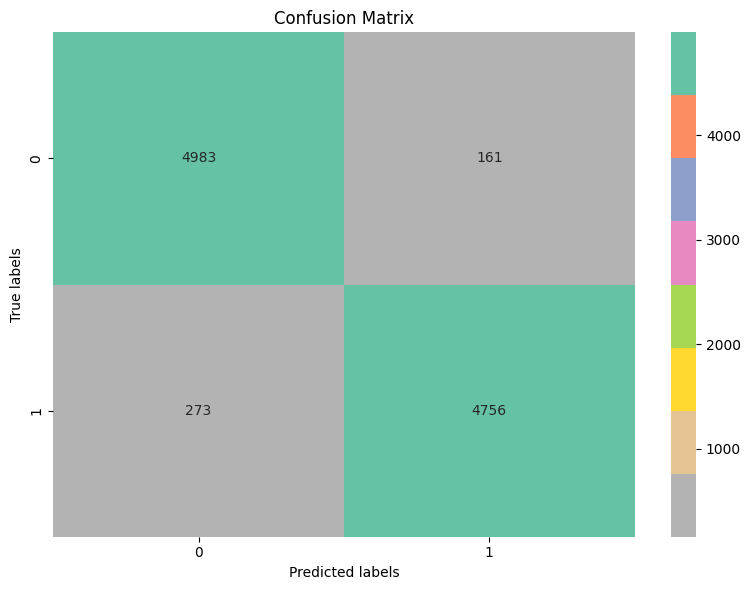

In [51]:
plot_cm(ysmavg_test, sm_rf_avg_pred)

#### Feature Importance

In [52]:
imp_smavg_rf = importance(rf, Xsmavg_train)
imp_smavg_rf

credit_rating               0.252
income_level                0.148
household_size              0.120
average_balance             0.107
credit_cards_held           0.100
random                      0.066
bank_accounts_open          0.032
mailer_type_Postcard        0.027
reward_Cash Back            0.026
mailer_type_Letter          0.025
homes_owned                 0.025
reward_Air Miles            0.021
own_your_home_No            0.012
reward_Points               0.012
own_your_home_Yes           0.011
overdraft_protection_Yes    0.008
overdraft_protection_No     0.008
Name: 0, dtype: float64

<Axes: xlabel='0'>

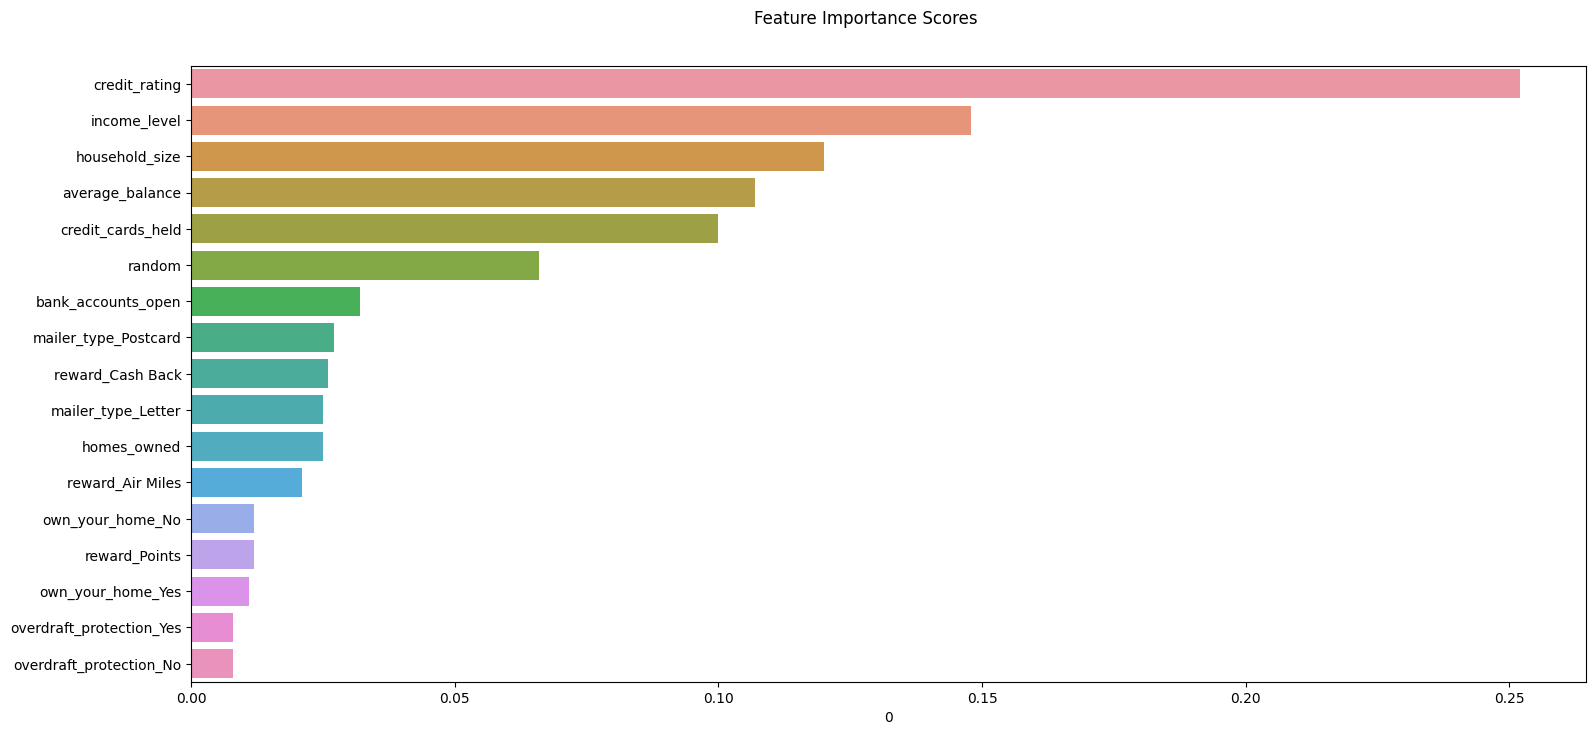

In [53]:
plot_importance(imp_smavg_rf)

#### Permutation Importance

In [54]:
train_impt, test_impt = perm_importance(rf, Xsm_avgbal, y_sm)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


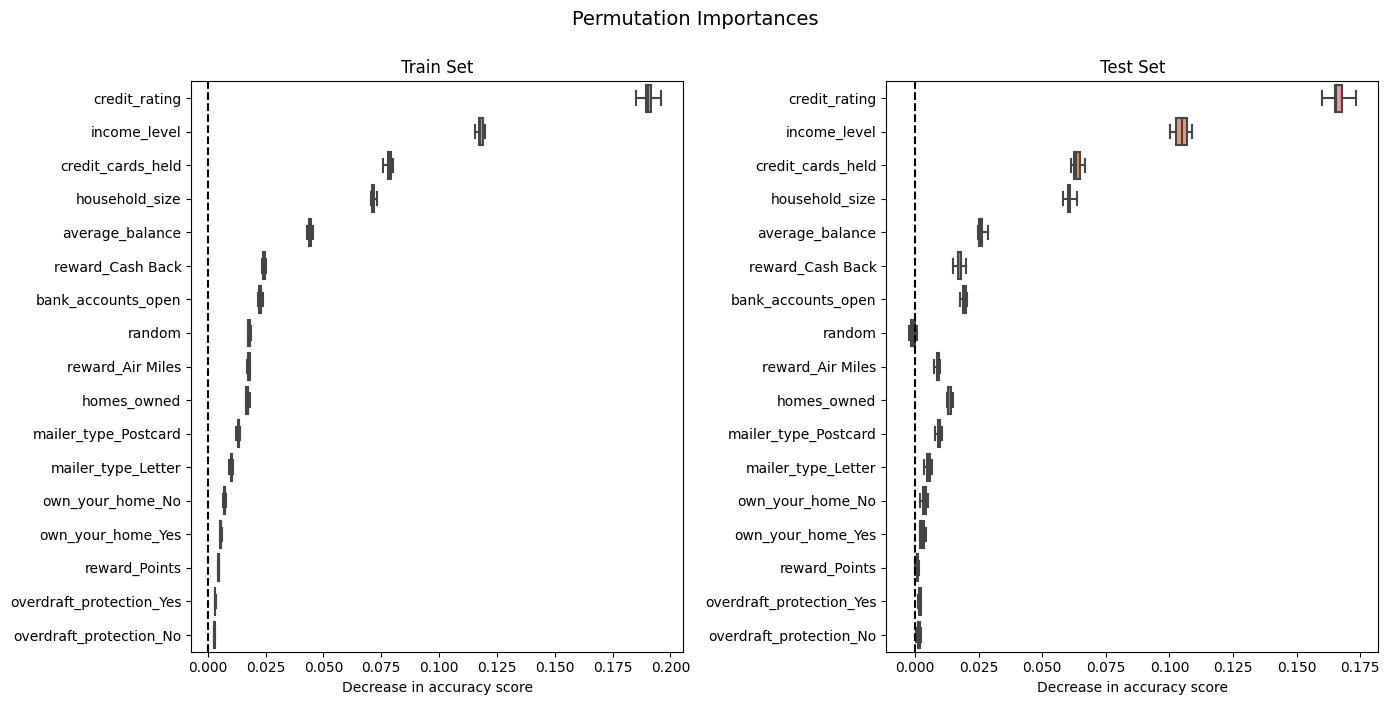

In [55]:
plot_perm_impt(train_impt, test_impt)

> **Note:** We can see that with synthetic data, the predictive power of the model is much higher. Without the imbalanced data, we are now able to predict which customers would accept the credit card offer.
>
> In terms of feature importance, here are the top 5 variables we found:
> 1. credit_rating
> 2. income_level
> 3. household_size
> 4. average_balance
> 5. credit_cards_held
>
> Meanwhile, permutation importance yields:
> 1. credit_rating
> 2. income_level
> 3. household_size
> 4. credit_cards_held
> 5. average_balance
>
> We can see that both feature imporance methods yielded the same top 5 variables, with little variation in the ranking.

### SMOTE Data with only the top 5 variables

We will check if keeping only the 5 variables would affect the overall performance of the model.


In [56]:
# Copy X
X1 = X_sm.copy()
X1.shape

(33910, 21)

In [57]:
# list of top 5 features
X_keep = ['credit_rating', 'income_level', 'credit_cards_held', 'household_size', 'average_balance']

In [58]:
X1 = X1[X_keep]
X1.columns

Index(['credit_rating', 'income_level', 'credit_cards_held', 'household_size',
       'average_balance'],
      dtype='object')

In [59]:
# train-test split
X1_train, X1_test, y1_train, y1_test = xy_split(X1, y_sm)

In [60]:
rf.fit(X1_train,y1_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(X1_train, y1_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X1_test, y1_test)))

rf1_pred = rf.predict(X1_test)

Training Accuracy Score: 1.00 
OOB Score: 0.91 
Validation Accuracy Score: 0.91


In [61]:
rf1_metrics = metrics_class(y1_test, rf1_pred)
rf1_metrics

Cohen Kappa Score    0.83
Accuracy             0.91
Precision            0.91
Recall               0.91
F1                   0.91
AUC Score            0.91
dtype: float64

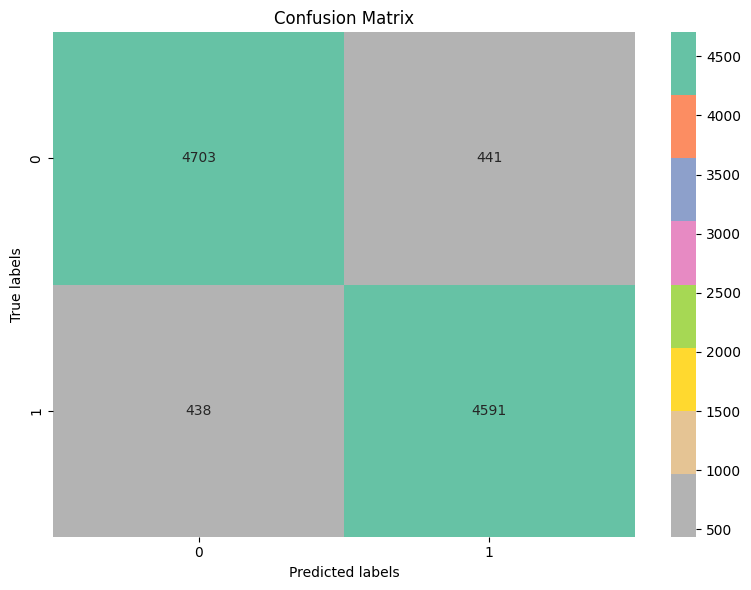

In [62]:
plot_cm(y1_test, rf1_pred)

#### Feature Importance

In [63]:
imp_sm_rf1 = importance(rf, X1_train)
imp_sm_rf1

credit_rating        0.301
average_balance      0.216
income_level         0.179
household_size       0.173
credit_cards_held    0.130
Name: 0, dtype: float64

<Axes: xlabel='0'>

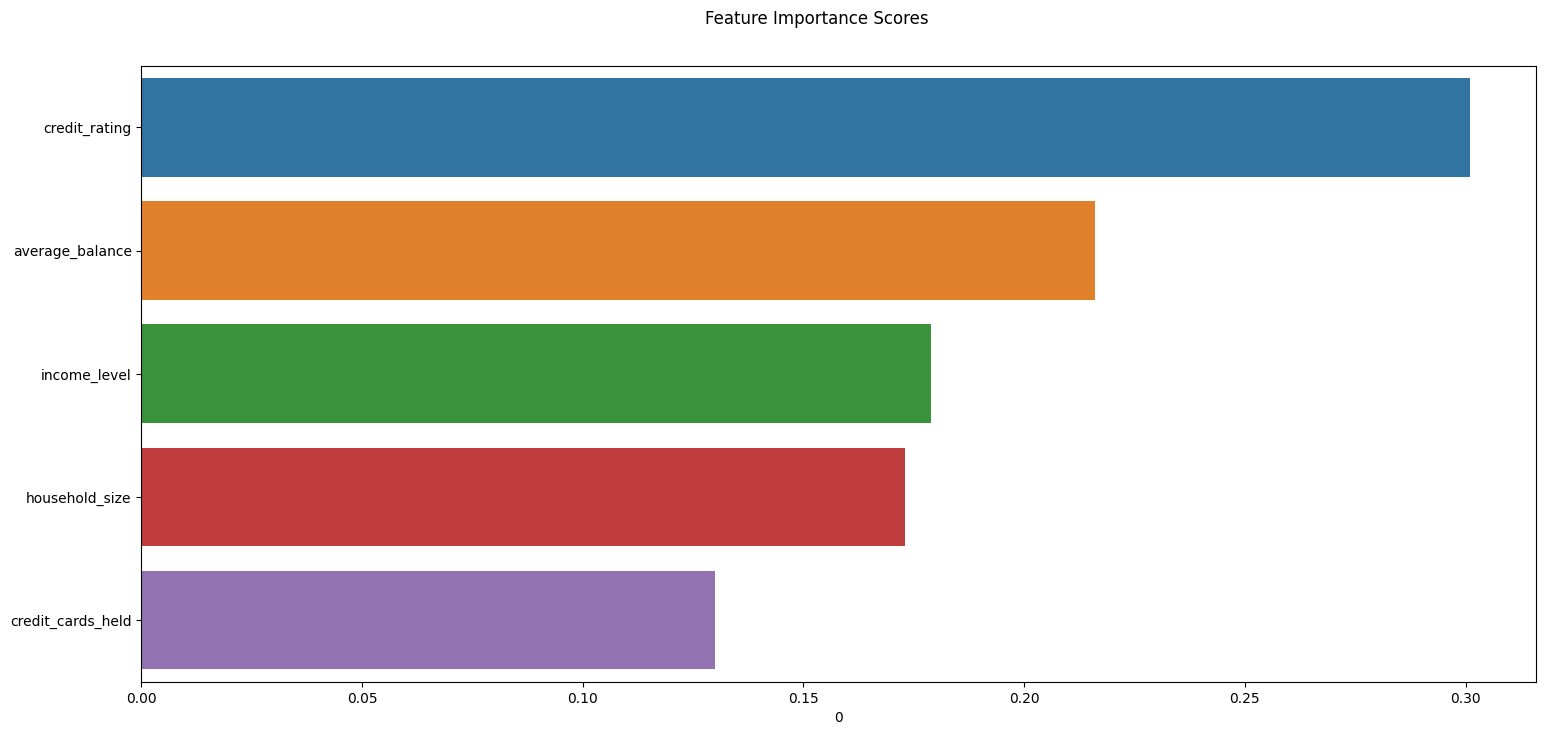

In [64]:
plot_importance(imp_sm_rf1)

#### Permutation Importance

In [65]:
train_impt, test_impt = perm_importance(rf, X1, y_sm)

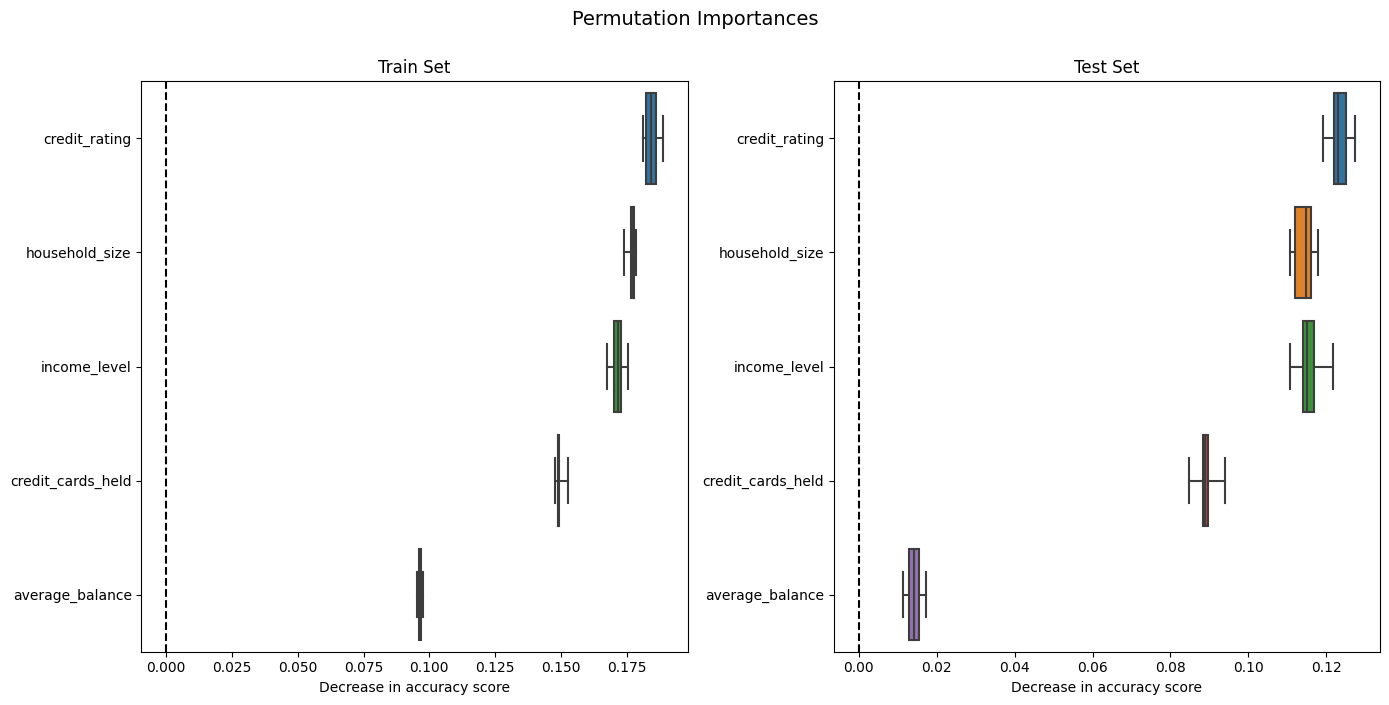

In [66]:
plot_perm_impt(train_impt, test_impt)

#### Now to double-check if without the top 5 variables, how the model would perform:

In [67]:
# new df without top variables
X2 = X_sm.drop(columns=(X_keep))
X2.columns

Index(['bank_accounts_open', 'homes_owned', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance', 'reward_Air Miles', 'reward_Cash Back',
       'reward_Points', 'mailer_type_Letter', 'mailer_type_Postcard',
       'overdraft_protection_No', 'overdraft_protection_Yes',
       'own_your_home_No', 'own_your_home_Yes', 'random'],
      dtype='object')

In [68]:
# train-test split
X2_train, X2_test, y2_train, y2_test = xy_split(X2, y_sm)

In [69]:
rf.fit(X2_train,y2_train)
print('Training Accuracy Score: {:.2f} \nOOB Score: {:.2f} \nValidation Accuracy Score: {:.2f}'.format(rf.score(X2_train, y2_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X2_test, y2_test)))

rf2_pred = rf.predict(X2_test)

Training Accuracy Score: 1.00 
OOB Score: 0.88 
Validation Accuracy Score: 0.88


In [70]:
rf2_metrics = metrics_class(y2_test, rf2_pred)
rf2_metrics

Cohen Kappa Score    0.76
Accuracy             0.88
Precision            0.86
Recall               0.90
F1                   0.88
AUC Score            0.88
dtype: float64

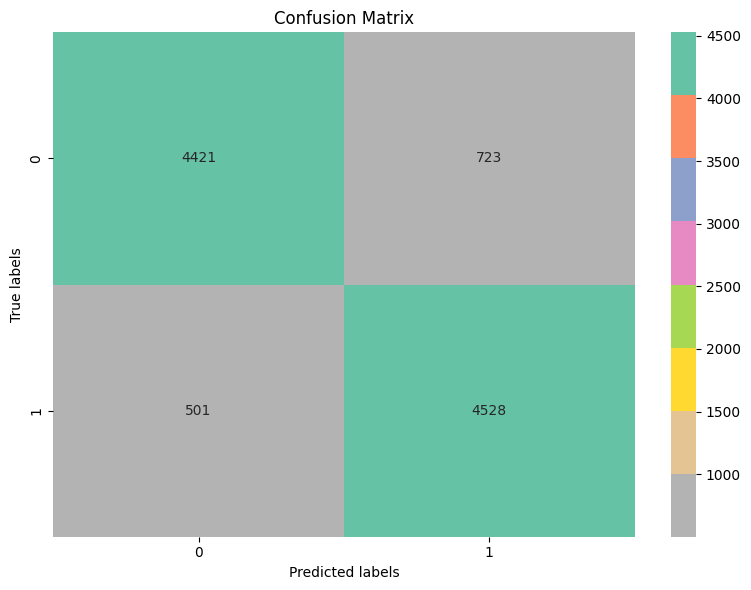

In [71]:
plot_cm(y2_test, rf2_pred)

> **Note:** We can see a lower overall performance when we drop the important variables.

#### Models Metrics

In [72]:
metrics = [rf_metrics, rf_avg_metrics, sm_rf_metrics, sm_rf_avg_metrics, rf1_metrics, rf2_metrics]
metrics_columns = ['original', 'orig_avg', 'smote', 'smote_avg', 'top_5', 'dropped_top']
results = pd.DataFrame(metrics, index=metrics_columns).T

In [73]:
results.columns

Index(['original', 'orig_avg', 'smote', 'smote_avg', 'top_5', 'dropped_top'], dtype='object')

In [74]:
results

,original,orig_avg,smote,smote_avg,top_5,dropped_top
Cohen Kappa Score,-0.00,0.00,0.94,0.91,0.83,0.76
Accuracy,0.94,0.94,0.97,0.96,0.91,0.88
Precision,0.00,0.11,0.97,0.97,0.91,0.86
Recall,0.00,0.00,0.96,0.95,0.91,0.90
F1,0.00,0.01,0.97,0.96,0.91,0.88
AUC Score,0.50,0.50,0.97,0.96,0.91,0.88


### AUC-ROC

In [75]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, rf_pred)
fpr2, tpr2, thresh2 = roc_curve(yavg_test,rf_avg_pred)
fpr3, tpr3, thresh3 = roc_curve(ysm_test, sm_rf_pred)
fpr4, tpr4, thresh4 = roc_curve(ysmavg_test, sm_rf_avg_pred)
fpr5, tpr5, thresh5 = roc_curve(y1_test, rf1_pred)
fpr6, tpr6, thresh6 = roc_curve(y2_test, rf2_pred)

#roc scores
roc_score1 = roc_auc_score(y_test, rf_pred)
roc_score2 = roc_auc_score(yavg_test,rf_avg_pred)
roc_score3 = roc_auc_score(ysm_test, sm_rf_pred)
roc_score4 = roc_auc_score(ysmavg_test, sm_rf_avg_pred)
roc_score5 = roc_auc_score(y1_test, rf1_pred)
roc_score6 = roc_auc_score(y2_test, rf2_pred)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
roc_score_rand = roc_auc_score(y_test, random_probs)

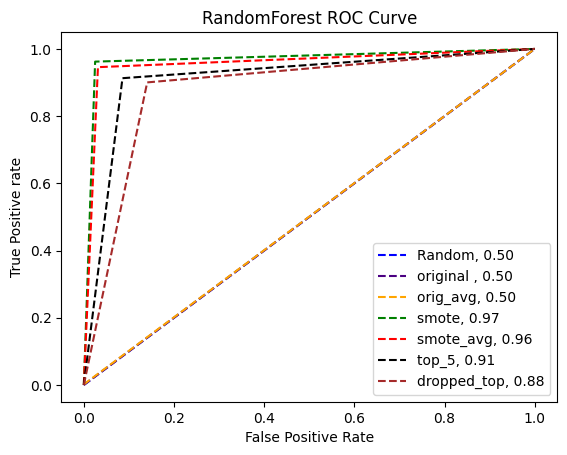

In [76]:
# plotting the roc curve
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label=f'Random, {roc_score_rand:.2f}')
plt.plot(fpr1, tpr1, linestyle='--',color='indigo', label=f'{metrics_columns[0]} , {roc_score1:.2f}')
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=f'{metrics_columns[1]}, {roc_score2:.2f}')
plt.plot(fpr3, tpr3, linestyle='--',color='green', label=f'{metrics_columns[2]}, {roc_score3:.2f}')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label=f'{metrics_columns[3]}, {roc_score4:.2f}')
plt.plot(fpr5, tpr5, linestyle='--',color='black', label=f'{metrics_columns[4]}, {roc_score5:.2f}')
plt.plot(fpr6, tpr6, linestyle='--',color='brown', label=f'{metrics_columns[5]}, {roc_score6:.2f}')

# title
plt.title('RandomForest ROC Curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_smotedata',dpi=300)
plt.show();